# Compare models on Nino indices

In [3]:
import os, torch, nc_time_axis, yaml
from importlib import reload
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ctp
from tqdm import tqdm
from joblib import Parallel, delayed, parallel_backend

import hyblim.geoplot as gpl
from hyblim.utils import metric

plt.style.use("../../paper.mplstyle")

def get_model_specs_by_name(experiments, exp_name):
    for exp in experiments:
        if exp['name'] == exp_name:
            return exp 
    return None

# Load list of experiments
with open("experiments.yaml", "r") as f:
    experiments = yaml.safe_load(f)

In [4]:
load_experiments = ['LIM', 'LSTM', 'LIM+LSTM']
datasplit = 'test'


nino_scores, nino_scores_month = {}, {}
for exp_name in load_experiments:
    nino_scores_exp, nino_scores_month_exp, num_traindata = [], [], []
    exp = get_model_specs_by_name(experiments, f"{exp_name}")
    if exp is None:
        print(f"Experiment {exp_name} (n{n_data}) not found")
        continue
    nino_frcst = xr.open_dataset(exp['paths'][0] + '/metrics/nino_frcst_test.nc').transpose('time', 'member', 'lag')
    nino_target = xr.open_dataset(exp['paths'][0] + '/metrics/nino_target_test.nc').transpose('time','lag')

    nino_scores[exp_name], nino_scores_month[exp_name] = metric.time_series_score(nino_frcst, nino_target)

/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/utils/metric.py:208: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_members = frcst.dims['member']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/utils/metric.py:208: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_members = frcst.dims['member']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/utils/metric.py:208: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

In [5]:
nino_scores['LSTM']['mse']

<xarray.Dataset> Size: 432B
Dimensions:  (lag: 9)
Coordinates:
  * lag      (lag) int64 72B 1 3 6 9 12 15 18 21 24
Data variables:
    nino12   (lag) float64 72B 0.07305 0.154 0.3373 ... 0.7197 0.762 0.7973
    nino3    (lag) float64 72B 0.04112 0.1303 0.3501 ... 0.9651 1.048 1.119
    nino34   (lag) float64 72B 0.03461 0.1126 0.3163 ... 1.034 1.142 1.235
    nino4    (lag) float64 72B 0.02512 0.08028 0.2057 ... 0.8237 0.9292 1.019
    nino5    (lag) float64 72B 0.03523 0.05451 0.07185 ... 0.1244 0.1364 0.1452

## Plot skill score averaged over all months

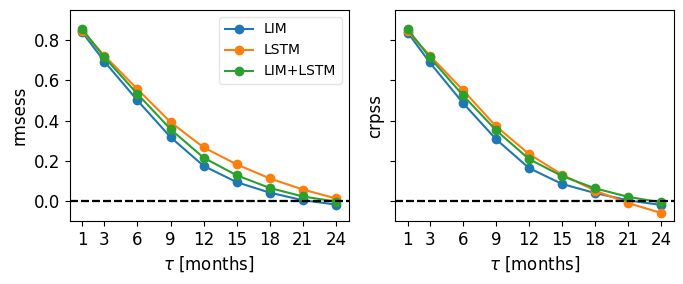

In [6]:
# Line plots 
reload(gpl)
model_name = ["LIM", "LSTM", "LIM+LSTM"] 
scores = ['rmsess', 'crpss']
idx_name = 'nino4'
plot_mean = True
ncols = len(scores)


fig, axs = plt.subplots(1, ncols, figsize=(7, 3.0),
                        sharex=True, sharey=True)

for i, score_name in enumerate(scores):
    for j, model in enumerate(model_name):
        ax = axs[i] if len(scores)>1 else axs

        score = nino_scores[model][score_name][idx_name]

        ax.plot(score['lag'], score, '-o', label=model)

        ax.set_xlabel(r'$\tau$ [months]')
        ax.set_ylabel(score_name)
        ax.axhline(0.0, color='k', linestyle='--')

    if i ==0:
        ax.legend(fontsize='small')
    

ax = axs[-1] if len(scores)>1 else axs
ax.set_ylim(-.1, 0.95)
_ = ax.set_xticks(score['lag'])

#gpl.enumerate_axes(axs, pos_x=0.01, pos_y=1.1, fontsize='medium')

### Compute skill score wrt to CS-LIM

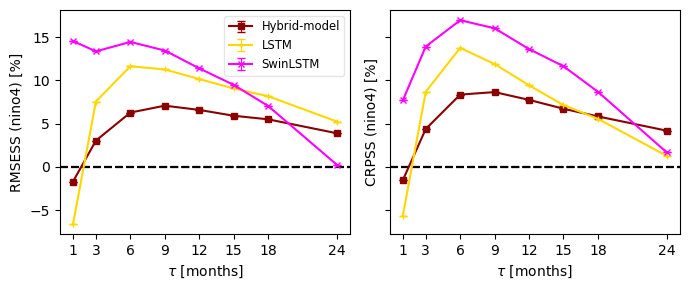

In [36]:
# Line plots 
reload(gpl)
baseline_key = 'CS-LIM (ssta, ssha)'
model_keys = ['Hybrid-model', 'LSTM', 'SwinLSTM']
scores = ['rmse', 'crps']
idx_name = 'nino4'
plot_mean = True
ncols = len(scores)
score_label = dict(rmse=f'RMSESS ({idx_name}) [%]', crps=f'CRPSS ({idx_name}) [%]')


fig, axs = plt.subplots(1, ncols, figsize=(7, 3.0),
                        sharex=True, sharey=True)

for i, score_name in enumerate(scores):
    baseline_score = metric_storer[baseline_key][score_name][idx_name]

    for j, modelkey in enumerate(model_keys):
        ax = axs[i] if len(scores)>1 else axs

        if score_name not in metric_storer[modelkey].keys(): 
            continue

        score = metric_storer[modelkey][score_name][idx_name]
        skill_score = (1 - score / baseline_score)*100

        if plot_mean:
            mean = skill_score.mean(dim='member')
            std = skill_score.std(dim='member')
            ax.errorbar(mean['lag'], mean, yerr=std, label=modelkey, **model_dict[modelkey]['pltattr'],
                        markersize=4, capsize=3, elinewidth=0.7) 
        else:
            for m in score['member']:
                ax.plot(skill_score['lag'], skill_score.sel(member=m), **plt_attr,
                        markersize=1, linewidth=0.7, alpha=0.5)

        ax.set_xlabel(r'$\tau$ [months]')
        ax.set_ylabel(score_label[score_name])
        ax.axhline(0.0, color='k', linestyle='--')

    if i ==0:
        ax.legend(fontsize='small')
    


ax = axs[-1] if len(scores)>1 else axs
#ax.set_ylim(-2, 10)
_ = ax.set_xticks(score['lag'])

#gpl.enumerate_axes(axs, pos_x=0.01, pos_y=1.1, fontsize='medium')

#plt.savefig(f'../../output/presentations/skill_score_with_lim_2.jpg', dpi=1000, bbox_inches='tight')

## Plot skill over months

### Absolute score per month

In [ ]:
# Plot skill score
metrickey = 'rmse_skill_vmonth'
pltspec = {
    'crps_vmonth' : dict(cmap='plasma_r', vmin=0, vmax=0.6),
    'rmse_skill_vmonth' : dict(cmap='plasma', vmin=0, vmax=0.9),
}
ids_name = ['nino5', 'nino4', 'nino3', 'nino12']
models = [list(metric_storer.keys())[1]]

fig, axs = plt.subplots(len(models), len(ids_name), 
                        figsize=(len(ids_name)*4, len(models)*3.5),
                        sharex=True, sharey=True)

for i, modelkey in enumerate(models):
    metric_month = metric_storer[modelkey][metrickey]
    for j, nino_idx in enumerate(ids_name):
        ax = axs[i, j] if len(models) > 1 else axs[j]
        skill_buff = metric_month[nino_idx].mean(dim='member')        
        im = ax.contourf(skill_buff['lag'], skill_buff['month'], skill_buff.data,
                         **pltspec[metrickey])
        ax.set_yticks(skill_buff['month'])
        ax.set_xticks(skill_buff['lag'])

        if i == len(models)-1:
            ax.set_xlabel(rf"$\tau$")
        if i ==0:
            ax.set_title(rf"{nino_idx}")
        if j == 0:
            ax.set_yticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
            #ax.set_ylabel("init. month" if key=='rmse_skill_imonth' else 'verif. month')
            ax.set_ylabel(f"{modelkey}")

cbar_ax = fig.add_axes([1, .2, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, orientation='vertical', extend='max', label=rf"{metrickey}")
#fig.suptitle(models)

### Score differences per month

In [ ]:
# Compare all to one skill score
reload(gpl)
metrickey = 'rmse_skill_vmonth' 
plparam = {
    'rmse_skill_vmonth': dict(cmap='RdBu_r', vmin=-0.15, vmax = 0.15, eps=0.025, centercolor="#FFFFFF"),
    'crps_vmonth': dict(cmap='RdBu', vmin=-0.1, vmax = 0.1, eps=0.01, centercolor="#FFFFFF"),
}
ids_name = ['nino5', 'nino4', 'nino3', 'nino12']
alpha = 0.95

models = list(metric_storer.keys())
fig, axs = plt.subplots(len(models)-1, len(ids_name), 
                        figsize=(len(ids_name)*4, (len(models)-1)*2.5),
                        sharex=True, sharey=True)

for i, modelkey in enumerate(models[1:]):
    verification_model = metric_storer[models[0]]
    comparison_model = metric_storer[modelkey]
    
    
    for j, nino_idx in enumerate(ids_name):
        skill_diff, pvalues = metric.mean_diff(comparison_model[metrickey][nino_idx],
                                               verification_model[metrickey][nino_idx],
                                               dim='member')
        if pvalues is not None:        
            skill_diff = xr.where(pvalues<=(1-alpha), skill_diff, np.nan)

        ax = axs[i, j] if len(models) > 1 else axs[j]
        im = gpl.plot_matrix(skill_diff, 'lag', 'month', ax=ax,
                             bar='discrete', add_bar=False, **plparam[metrickey])

        ax.set_yticks(skill_diff['month'])
        ax.set_xticks(skill_diff['lag'])

        if i ==0:
            ax.set_title(rf"{nino_idx}")
        if j == 0:
            ax.set_yticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
            #ax.set_ylabel("init. month" if key=='skill_init_month' else 'verif. month')
            ax.set_ylabel(rf"{modelkey}", fontsize=12)
        if i == len(models)-2:
            ax.set_xlabel(r"$\tau$")

cbar_ax = fig.add_axes([1, .2, 0.01, 0.6])
fig.colorbar(im['im'], cax=cbar_ax, orientation='vertical', extend='both', label=rf"$\Delta$ {metrickey}")
plt.suptitle(f"Ref: {models[0]}")

Compare two selected models

In [ ]:
# Compare two selected models
reload(metric)
metrickey = 'rmse_skill_vmonth' #'skill_month', 'skill_init_month'
modelkey1, modelkey2 = 'CS-LIM+CS-LSTM', 'CS-LIM'
alpha = 0.95
ids_name = ['nino5', 'nino4', 'nino3', 'nino12']
plparam = {
    'rmse_skill_vmonth': dict(vmin=-0.15, vmax = 0.15, eps=0.025, centercolor="#FFFFFF")
}

# Plotting 
fig, axs = plt.subplots(1, len(ids_name), figsize=(len(ids_name)*4, 3.5),
                        sharex=True, sharey=True)

for i, nino_idx in enumerate(ids_name):
    skill_diff, pvalues = metric.mean_diff(metric_storer[modelkey1][metrickey][nino_idx],
                                           metric_storer[modelkey2][metrickey][nino_idx],
                                           dim='member')
    if pvalues is not None:
        skill_diff = xr.where(pvalues<=(1-alpha), skill_diff, np.nan)

    ax = axs[i] if len(ids_name) > 1 else axs
    im = gpl.plot_matrix(skill_diff, 'lag', 'month', ax=ax,
                         cmap='RdBu_r', bar='discrete', add_bar=False, **plparam[metrickey])

    ax.set_xlabel(r"$\tau$")
    ax.set_xticks(skill_diff['lag'])
    ax.set_yticks(skill_diff['month'])
    if i == 0:
        #ax.set_ylabel("init. month" if metrickey=='skill_init_month' else 'verif. month')
        ax.set_yticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
        ax.set_ylabel(f"{modelkey1} - {modelkey2}")
    ax.set_title(rf"{nino_idx}")

cbar_ax = fig.add_axes([1, .2, 0.01, 0.55])
fig.colorbar(im['im'], cax=cbar_ax, orientation='vertical', extend='both',
             label=rf"$\Delta$ {metrickey}")

#fig.suptitle(f"{modelkey1} - {modelkey2}")


## Quantile - Quantile plot

In [ ]:

qq = {}
for modelkey, indices_hindcast in model_indices.items():
    indices_hindcast = indices_hindcast[0] # Select only first member
    # Select events
    x = indices_hindcast['target']
    # Compute ensemble mean
    if 'frcst' in indices_hindcast.keys(): 
        if 'member' in indices_hindcast['frcst'].dims: 
            x_hat_mean = indices_hindcast['frcst'].mean(dim='member')
        else:
            x_hat_mean = indices_hindcast['frcst']
    else:
        x_hat_mean = indices_hindcast['frcst_mean']

    # Compute quantiles for x and x_hat_mean
    quantiles = np.linspace(0, 1, 100)
    x_quantiles = x.quantile(quantiles, dim='time')
    x_hat_quantiles = x_hat_mean.quantile(quantiles, dim='time')
    qq[modelkey] = dict(q_target=x_quantiles, q_frcst=x_hat_quantiles)

#qq.pop('Persistence')

In [ ]:
# Create Q-Q plot
nino_idx = 'nino34'
lag_arr = x_quantiles['lag'][::2]
ncols = len(lag_arr)
fig, axs = plt.subplots(1, ncols, figsize=(3.5*ncols, 3), sharex=True, sharey=True)
for key, quantile_dict in qq.items():
    for i, lag in enumerate(lag_arr):
        q_x = quantile_dict['q_target'].sel(lag=lag)[nino_idx]
        q_x_hat = quantile_dict['q_frcst'].sel(lag=lag)[nino_idx]

        if 'pltattr' in model_dict[key].keys():
            plt_attr = model_dict[key]['pltattr'] 
        else:
            plt_attr = dict(marker='.')

        axs[i].plot(q_x, q_x_hat, label=key, markersize=0, lw=2, **plt_attr)
        axs[i].plot([q_x.min(), q_x.max()], [q_x.min(), q_x.max()], 'k--')

        axs[i].set_xlabel(f"Q data ")
        axs[i].set_title(f"lag={lag.values}")
        if i == 0:
            axs[i].set_ylabel("Q hindcast")
            axs[i].legend(fontsize=12)

## Probabilistic event scores

In [ ]:
import scipy.stats as stats
import sklearn.metrics as skm
import sklearn.calibration as calibration

def event_score(target_bool, probabilities):
    lag_arr = probabilities['lag'].values
    n_bins = 10
    scores = {'fpr': [], 'tpr': [], 'auc': np.zeros(len(lag_arr)),
              'prob_data': [], 'prob_pred': []} 
    for i, lag in enumerate(lag_arr):
        # ROC
        fpr, tpr, thresholds = skm.roc_curve(target_bool.sel(lag=lag).values, 
                                             probabilities.sel(lag=lag).values,
                                             pos_label=1)
        scores['fpr'].append(fpr)
        scores['tpr'].append(tpr)
        auc_score = skm.roc_auc_score(target_bool.sel(lag=lag).values,
                                      probabilities.sel(lag=lag).values)
        scores['auc'][i] = auc_score

        # Reliability diagram
        prob_true, prob_pred = calibration.calibration_curve(
            target_bool.sel(lag=lag).values, probabilities.sel(lag=lag).values,
            pos_label=1, n_bins=n_bins, strategy='quantile'
        )
        scores['prob_data'].append(prob_true) 
        scores['prob_pred'].append(prob_pred) 

    return scores, lag_arr

In [ ]:
# EN events
percentile = 0.05
target_month=[12, 1, 2]

en_metrics = {}
for modelkey, indices_hindcast in model_indices.items():
    indices_hindcast = indices_hindcast[0] # Select only first member
    # Select events
    nino34 = indices_hindcast['target']['nino34']
    threshold = nino34.std(dim='time', skipna=True).values[0]
    #threshold = nino34.quantile(1-percentile, dim='time', skipna=True).values[0]
    target_bool = xr.where((nino34.rolling(time=3, center=True).mean() > threshold)
                           & (nino34.time.dt.month.isin(target_month)),
                           1, 0)
    print(f"EN threshold:{threshold}, num. data = {np.count_nonzero(target_bool.isel(lag=0))}")
    # Get probabilities
    if 'frcst' in indices_hindcast.keys():
        probabilities = (indices_hindcast['frcst']['nino34'] > threshold).mean(dim='member')
    else:
        mean = indices_hindcast['frcst_mean']['nino34']
        std = indices_hindcast['frcst_std']['nino34']
        prob = 1 - stats.norm.cdf(threshold, loc=mean, scale=std)
        probabilities = xr.DataArray(prob, coords=mean.coords)

    # Comput event scores
    scores, lag_arr = event_score(target_bool, probabilities) 
    en_metrics[modelkey] = scores

# LN events
ln_metrics = {}
for modelkey, indices_hindcast in model_indices.items():
    indices_hindcast = indices_hindcast[0] # Select only first member
    # Select events
    nino34 = indices_hindcast['target']['nino34']
    threshold = -1* nino34.std(dim='time', skipna=True).values[0]
    #threshold = nino34.quantile(percentile, dim='time', skipna=True).values[0]
    target_bool = xr.where((nino34.rolling(time=3, center=True).mean() < threshold)
                           & (nino34.time.dt.month.isin(target_month)),
                           1, 0)
    print(f"LN threshold:{threshold}, num. data = {np.count_nonzero(target_bool.isel(lag=0))}")
    # Get probabilities
    if 'frcst' in indices_hindcast.keys():
        probabilities = (indices_hindcast['frcst']['nino34'] < threshold).mean(dim='member')
    else:
        mean = indices_hindcast['frcst_mean']['nino34']
        std = indices_hindcast['frcst_std']['nino34']
        prob = stats.norm.cdf(threshold, loc=mean, scale=std)
        probabilities = xr.DataArray(prob, coords=mean.coords)

    # Comput event scores
    scores, lag_arr = event_score(target_bool, probabilities) 
    ln_metrics[modelkey] = scores

In [ ]:
# Plot ROC curves
nrow = len(lag_arr)
fig, axs = plt.subplots(nrow, 1, figsize=(5, 1*nrow),
                        sharex=True, sharey=True)
for modelkey, scores in en_metrics.items():
    plt_attr = model_dict[modelkey]['pltattr'] if 'pltattr' in model_dict[modelkey].keys() else dict() 
    for i, lag in enumerate(lag_arr):
        label = f"{modelkey}" if i == 0 else None

        axs[i].plot(scores['fpr'][i], scores['tpr'][i], label=label, **plt_attr, markersize=0)
    
# Axes properties
for i, ax in enumerate(axs):
    ax.set_ylabel(f"lag={lag_arr[i]}")
fig.legend(bbox_to_anchor=(1,1), loc="upper left")


In [ ]:
# Plot reliability diagram
nrow = len(lag_arr)
fig, axs = plt.subplots(nrow, 2, figsize=(3*2, 2*nrow),
                        sharex=True, sharey=True)
# El Nino
for modelkey, scores in en_metrics.items():
    plt_attr = model_dict[modelkey]['pltattr'] if 'pltattr' in model_dict[modelkey].keys() else dict() 
    for i, lag in enumerate(lag_arr):
        label = f"{modelkey}" if i == 0 else None
        axs[i,0].plot(scores['prob_data'][i], scores['prob_pred'][i], label=label, **plt_attr, markersize=0)
        axs[i,0].set_ylabel(rf"Frcst prob ($\tau$={lag})")
axs[0,0].set_title(f"El Nino")

# La Nina
for modelkey, scores in ln_metrics.items():
    plt_attr = model_dict[modelkey]['pltattr'] if 'pltattr' in model_dict[modelkey].keys() else dict() 
    for i, lag in enumerate(lag_arr):
        label = f"{modelkey}" if i == 0 else None
        axs[i,1].plot(scores['prob_data'][i], scores['prob_pred'][i], label=label, **plt_attr, markersize=0)
axs[0,1].set_title(f"La Nina")
    
# Axes properties
for i, ax in enumerate(axs.flatten()):
    ax.plot([0, 1], [0, 1], 'k--')

axs[-1,0].set_xlabel('Observed Frequency')
axs[-1,1].set_xlabel('Observed Frequency')
axs[0,0].legend(fontsize=10)

In [ ]:
# Plot AUC
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7, 3))
for modelkey, scores in en_metrics.items():
    plt_attr = model_dict[modelkey]['pltattr'] if 'pltattr' in model_dict[modelkey].keys() else dict() 
    ax1.plot(lag_arr, scores['auc'], label=modelkey, **plt_attr, markersize=0)
    ax1.set_title(f"El Nino")
#    ax1.set_title(f"{(1-percentile)*100}%")

for modelkey, scores in ln_metrics.items():
    plt_attr = model_dict[modelkey]['pltattr'] if 'pltattr' in model_dict[modelkey].keys() else dict() 
    ax2.plot(lag_arr, scores['auc'], **plt_attr, markersize=0)
    ax2.set_title(f"La Nina")
#    ax2.set_title(f"{percentile*100}%")

for ax in (ax1, ax2):
    ax.set_xticks(lag_arr)
    ax.set_xlabel('lag')
    ax.set_ylabel('AUC')

fig.legend(bbox_to_anchor=(1,0.9), loc="upper left")


## Forecast specific events 

In [ ]:
def rollout_events(hindcast: dict, times: np.ndarray, idx_time_init):
    """Get rollout of events specified by time index."""
    lag_arr = hindcast['lag'].values
    x = np.zeros((len(idx_time_init), len(lag_arr)))
    for i, idx in enumerate(idx_time_init):
        if idx + np.max(lag_arr) > len(times):
            continue
        tmp_times = times[idx+lag_arr]
        x[i, :] = hindcast.sel(time=xr.DataArray(tmp_times, dims='z'),
                                   lag=xr.DataArray(lag_arr, dims='z')).values
    da_hat = xr.DataArray(
        x, coords=dict(init_time=times[idx_time_init], lag=lag_arr),
        name=hindcast.name
    ) 
    return da_hat 


### 1. Strongest EN and LN and double dip LN

In [ ]:
events = {
    'EN' : {1:"1513-12-01"},
    'LN' : {1: "1507-12-01"},
}

In [ ]:
percentile = 0.05
target_month = 12
init_time = 9
event_type = 'LN'

#idx_events = [1]
idx_events = np.arange(0, 10) 
nino_idx = 'nino34'
fig, axs = plt.subplots(len(idx_events), figsize=(9, len(idx_events)*3),
                        sharex=True, sharey=True)


for m, (modelkey, indices_hindcast) in enumerate(model_indices.items()):
    indices_hindcast = indices_hindcast[0] # Select only first member
    # Select events
    nino34 = indices_hindcast['target']['nino34'].isel(lag=0).drop('lag')
    # threshold = nino34.quantile(1-percentile, dim='time', skipna=True)
    if event_type == 'EN': # El Nino
        threshold = nino34.std(dim='time')
        idx_init = np.where(
            (nino34.rolling(time=3).mean() > threshold) & 
            (nino34.time.dt.month.isin([target_month]))
        )[0]-init_time
    elif event_type == 'LN': # La Nina 
        threshold = -1 * nino34.std(dim='time')
        idx_init = np.where(
            (nino34.rolling(time=3).mean() < threshold) & 
            (nino34.time.dt.month.isin([target_month]))
        )[0]-init_time
    else:
        raise ValueError(f"Event type is not correct!")

    x = rollout_events(indices_hindcast['target'][nino_idx],
                       nino34['time'].data, idx_init)

    if 'frcst' in indices_hindcast.keys():
        frcst = indices_hindcast['frcst'][nino_idx]
        x_frcst = []
        for member in frcst['member']:
            x_frcst.append(
                rollout_events(frcst.sel(member=member), nino34['time'].data, idx_init)
            )
        x_frcst = xr.concat(x_frcst, dim='member')
    else:
        x_mu = rollout_events(indices_hindcast['frcst_mean'][nino_idx],
                       nino34['time'].data, idx_init)
        x_std = rollout_events(indices_hindcast['frcst_std'][nino_idx],
                           nino34['time'].data, idx_init)


    # Plot events
    plt_attr = model_dict[modelkey]['pltattr'] if 'pltattr' in model_dict[modelkey].keys() else dict() 
    for i, idx in enumerate(idx_events):
        lags = x['lag']
        ax = axs[i] if len(idx_events) > 1 else axs

        if m == 0:
            ax.plot(lags, x.isel(init_time=idx), '--k', label='data')
            ax.set_title(f"Event {idx_init[idx]+init_time}: {nino34['time'].values[idx_init[idx]+init_time]}")

        if 'frcst' in indices_hindcast.keys():
            for member in x_frcst['member']:
                ax.plot(lags, x_frcst.sel(member=member).isel(init_time=idx),
                            **plt_attr, lw=0.5, markersize=0, alpha=0.5)
                
            x_mu = x_frcst.mean(dim='member')
            x_std = x_frcst.std(dim='member')

        im = ax.plot(lags, x_mu.isel(init_time=idx), label=f"{modelkey}", **plt_attr, markersize=0)
        ax.fill_between(lags, x_mu.isel(init_time=idx)-x_std.isel(init_time=idx),
                            x_mu.isel(init_time=idx)+x_std.isel(init_time=idx),
                            color=im[0].get_color(), alpha=0.2)
        
        ax.set_ylabel(nino_idx)
        

        ax.legend(bbox_to_anchor=(1,0.9), loc="upper left")
        ax.set_xlabel(r'$\tau$')
        ax.set_xticks(lags)

In [ ]:
# Select strong EN/LN
percentile = 0.2
init_month = 12
event_storer = {'strong_EN':[], 'strong_LN':[], 'double_LN': []}
for modelkey, indices in model_indices.items():
    ens_storer_en = dict()
    ens_storer_ln = dict()
    ens_storer_double_ln = dict()

    frcst = indices['frcst_mean']
    target = indices['target'].isel(lag=0)

    # Select extreme EN in Jan
    threshold_en = target['nino34'].quantile(1-percentile, dim='time', skipna=True)
    idx_init_en = np.where(
        (target['nino34'].rolling(time=3).mean() > threshold_en) & 
        (target['nino34'].time.dt.month.isin([init_month]))
    )[0]-12
    strong_en = rollout_selected_times(target, frcst, idx_init_en)
    # Save ensemble
    for key, da in strong_en.items():
        if key in list(ens_storer_en.keys()):
            ens_storer_en[key].append(da)
        else:
            ens_storer_en[key] = [da]

    # Select strong LN in Jan
    threshold_ln = target['nino34'].quantile(percentile, dim='time', skipna=True)
    idx_init_ln = np.where(
        (target['nino34'].rolling(time=3).mean() < threshold_ln) & 
        (target['nino34'].time.dt.month.isin([init_month]))
    )[0]-12
    strong_ln = rollout_selected_times(target, frcst, idx_init_ln)
    # Save ensemble
    for key, da in strong_ln.items():
        if key in list(ens_storer_ln.keys()):
            ens_storer_ln[key].append(da)
        else:
            ens_storer_ln[key] = [da]
    
    # Double dip LN
    idx_ln = np.where(
        (target['nino34'].rolling(time=3).mean() < -1 *target['nino34'].std())
        & (target['nino34'].time.dt.month.isin([1]))
    )[0]
    ln_years = np.unique(target.isel(time=idx_ln).time.dt.year)
    double_ln_second_year = ln_years[np.where(ln_years[:-1] - ln_years[1:] == -1)[0]+1]
    idx_double_ln_init = np.where(
       np.isin(target.time.dt.year, double_ln_second_year)
       & (target['nino34'].time.dt.month.isin([1]))
    )[0] - 24
    double_ln = rollout_selected_times(target, frcst, idx_double_ln_init)
    # Save ensemble
    for key, da in double_ln.items():
        if key in list(ens_storer_double_ln.keys()):
            ens_storer_double_ln[key].append(da)
        else:
            ens_storer_double_ln[key] = [da]


    # Concat ensembles
    for key, arr in ens_storer_en.copy().items():
        ens_storer_en[key] = xr.concat(arr, dim='ensemble')
        ens_storer_en['model'] = name
    event_storer['strong_EN'].append(ens_storer_en)

    for key, arr in ens_storer_ln.copy().items():
        ens_storer_ln[key] = xr.concat(arr, dim='ensemble')
        ens_storer_ln['model'] = name
    event_storer['strong_LN'].append(ens_storer_ln)

    for key, arr in ens_storer_double_ln.copy().items():
        ens_storer_double_ln[key] = xr.concat(arr, dim='ensemble')
        ens_storer_double_ln['model'] = name
    event_storer['double_LN'].append(ens_storer_double_ln)

print(f"Q({1-percentile}): {threshold_en.data}")
print(f"Q({percentile}): {threshold_ln.data}")
print(f"STD: {target['nino34'].std(dim='time', skipna=True).data}")

Plot data spread

In [ ]:
nino_var = 'nino4'
std = target[nino_var].std(dim='time', skipna=True)
event_storer_temp = event_storer

fig, axs = plt.subplots(1,len(event_storer), figsize=(len(event_storer)*4,4), sharex=True, sharey=True)
for i, event_type in enumerate(event_storer.keys()):
    # Target
    x_target = event_storer[event_type][0]['target'].stack(s=('ensemble', 'sample'))[nino_var]
    axs[i].errorbar(x_target['lag'], x_target.mean(dim='s').data, 
                    yerr=x_target.std(dim='s').data,
                    marker='o', color='k', label=f"n={len(x_target['s'])}",
                    capsize=3, elinewidth=0.7) 
    for s in x_target['s']:
        axs[i].plot(x_target['lag'], x_target.sel(s=s).data, '-', color='grey',
                    alpha=0.7, lw=0.3)

    axs[i].set_xlabel('lag')
    axs[i].set_xticks(x_target['lag'].data)
    axs[i].set_ylim([-3, 3])
    axs[i].set_title(event_type)
    axs[i].axhline( std, color='k', alpha=0.5)
    axs[i].axhline(-std, color='k', alpha=0.5)
    axs[i].legend(loc=1)

Plot forecast mean of different models

In [ ]:
std = target[nino_var].std(dim='time', skipna=True)

fig, axs = plt.subplots(1,len(event_storer), figsize=(len(event_storer)*5,4), sharex=True, sharey=True)
for i, event_type in enumerate(list(event_storer.keys())):
    # Target
    x_target = event_storer[event_type][0]['target'].stack(s=('ensemble', 'sample'))[nino_var]
    axs[i].errorbar(x_target['lag'], x_target.mean(dim='s').data, 
                    yerr=x_target.std(dim='s').data,
                    marker='o', color='k', label='data',
                    capsize=3, elinewidth=0.7) 
    #p = axs[i].plot(x_target['lag'], x_target.mean(dim='s').data, 'o-', color='k', label='data')
    for s in x_target['s']:
        axs[i].plot(x_target['lag'], x_target.sel(s=s).data, '-', color='grey',
                    alpha=0.3, lw=0.3)

    for model in event_storer[event_type]:
        # Frcst 
        x_frcst = model['frcst'].stack(s=('ensemble', 'sample'))[nino_var]
        p = axs[i].errorbar(x_frcst['lag'], x_frcst.mean(dim='s').data, 
                        yerr=x_frcst.std(dim='s').data, **model_dict[model['model']]['pltattr'],
                        label=f"{model['model']}",
                        capsize=3, elinewidth=0.7)
        #p = axs[i].plot(x_frcst['lag'], x_frcst.mean(dim='s').data, 'o-', label=f"{model['model']}")
        #for s in x_frcst['s']:
        #    axs[i].plot(x_frcst['lag'], x_frcst.sel(s=s).data, '-', color=p[0].get_color(),
        #            alpha=0.2, lw=0.3)

    axs[i].set_xlabel('lag')
    axs[i].set_xticks(x_target['lag'].data)
    axs[i].set_ylim([-2, 2])
    axs[i].set_title(event_type)
    axs[i].axhline( std, color='k', alpha=0.5)
    axs[i].axhline(-std, color='k', alpha=0.5)

axs[0].set_ylabel(nino_var)
axs[-1].legend()#bbox_to_anchor=(1,1), loc="upper left")



Plot skill score.

In [ ]:
score = 'corr'
fig, axs = plt.subplots(1,len(event_storer), figsize=(len(event_storer)*5,4), sharex=True, sharey=True)
for i, event_type in enumerate(event_storer.keys()):
    for j, model in enumerate(event_storer[event_type]):
        ss = model[score][nino_var]
        pltspec = model_dict[model['model']]['pltattr']
        ax = axs[i]
        ax.errorbar(ss['lag'], ss.mean(dim='ensemble').data, 
                        yerr=ss.std(dim='ensemble').data,
                        **pltspec,
                        label=f"{model['model']}",
                        capsize=3, elinewidth=0.7) 

    if i == 0:
        ax.set_ylabel(f"{score} score {nino_var}")
    if i == len(event_storer)-1:
        ax.legend()#bbox_to_anchor=(1,1), loc="upper left")

    ax.set_xlabel('lag')
    ax.set_xticks(ss['lag'].data)
    if score == 'skill':
        ax.set_ylim([-1, 1])
        ax.axhline(0.0, color='k')
    elif score == 'corr':
        ax.set_ylim([-.1, 1])
        ax.axhline(0.5, color='k')
    ax.grid(axis='y')
    ax.set_title(event_type)
#   ax.set_title(event_type)

# Paperplots

## Average skill score

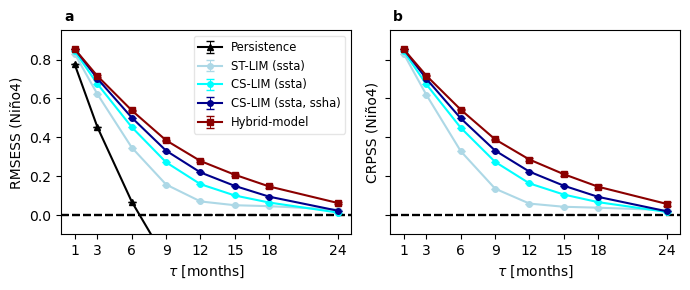

In [5]:
# Line plots 
reload(gpl)
model_name = ['Persistence', 'ST-LIM (ssta)', 'CS-LIM (ssta)', 'CS-LIM (ssta, ssha)', 'Hybrid-model'] 
scores = ['rmse_skill', 'crpss']
idx_name = 'nino4'
plot_mean = True
ncols = len(scores)
nino_label = dict(nino12='Niño1+2', nino3='Niño3', nino34='Niño3.4', nino4='Niño4', nino5='Niño5')
score_label = dict(rmse_skill=f'RMSESS ({nino_label[idx_name]})', crpss=f'CRPSS ({nino_label[idx_name]})')


fig, axs = plt.subplots(1, ncols, figsize=(7, 3),
                        sharex=True, sharey=True)

for i, score_name in enumerate(scores):
    for j, (metric_name, metric_dict) in enumerate(metric_storer.items()):
        ax = axs[i] if len(scores)>1 else axs

        if metric_name not in model_name:
            continue
        if (score_name not in metric_dict.keys()): 
            continue
        else:
            score = metric_dict[score_name][idx_name]

        if 'pltattr' in model_dict[metric_name].keys():
            plt_attr = model_dict[metric_name]['pltattr'] 
        else:
            plt_attr = dict(marker='.')

        if plot_mean:
            mean = score.mean(dim='member')
            std = score.std(dim='member')
            ax.errorbar(mean['lag'], mean, yerr=std, label=metric_name, **plt_attr,
                        markersize=4, capsize=3, elinewidth=0.7) 
        else:
            for m in score['member']:
                ax.plot(score['lag'], score.sel(member=m), **plt_attr,
                        markersize=1, linewidth=0.7, alpha=0.5)

        ax.set_xlabel(r'$\tau$ [months]')
        ax.set_ylabel(score_label[score_name])
        ax.axhline(0.0, color='k', linestyle='--')

    if i ==0:
        ax.legend(fontsize='small')

ax = axs[-1] if len(scores)>1 else axs
ax.set_ylim(-.1, 0.95)
_ = ax.set_xticks(score['lag'])

gpl.enumerate_axes(axs, pos_x=0.01, pos_y=1.1, fontsize='medium')

plt.savefig(f'../../output/paperplots/skill_score_with_lim.jpg', dpi=1000, bbox_inches='tight')

In [ ]:
# Line plots 
reload(gpl)
#model_name = ['Persistence', 'ST-LIM (ssta)', 'CS-LIM (ssta)', 'CS-LIM (ssta, ssha)', 'Hybrid-model'] 
model_name = ['Persistence', 'CS-LIM', 'SwinLSTM', 'LSTM', 'Hybrid-model']
scores = ['rmse_skill', 'crpss']
idx_name = 'nino4'
plot_mean = True
ncols = len(scores)
score_label = dict(rmse_skill=f'RMSE-SS ({idx_name})', crpss=f'CRPSS ({idx_name})')


fig, axs = plt.subplots(1, ncols, figsize=(7, 3),
                        sharex=True, sharey=True)

for i, score_name in enumerate(scores):
    for j, (metric_name, metric_dict) in enumerate(metric_storer.items()):
        ax = axs[i] if len(scores)>1 else axs

        if metric_name not in model_name:
            continue
        if (score_name not in metric_dict.keys()): 
            continue
        else:
            score = metric_dict[score_name][idx_name]

        if 'pltattr' in model_dict[metric_name].keys():
            plt_attr = model_dict[metric_name]['pltattr'] 
        else:
            plt_attr = dict(marker='.')

        if plot_mean:
            mean = score.mean(dim='member')
            std = score.std(dim='member')
            ax.errorbar(mean['lag'], mean, yerr=std, label=metric_name, **plt_attr,
                        markersize=4, capsize=3, elinewidth=0.7) 
        else:
            for m in score['member']:
                ax.plot(score['lag'], score.sel(member=m), **plt_attr,
                        markersize=1, linewidth=0.7, alpha=0.5)

        ax.set_xlabel(r'$\tau$ [months]')
        ax.set_ylabel(score_label[score_name])
        ax.axhline(0.0, color='k', linestyle='--')

    if i ==0:
        ax.legend(fontsize='small')

ax = axs[-1] if len(scores)>1 else axs
ax.set_ylim(-.1, 0.95)
_ = ax.set_xticks(score['lag'])

gpl.enumerate_axes(axs, pos_x=0.01, pos_y=1.1, fontsize='medium')

plt.savefig(f'../../output/paperplots/skill_score_with_baseline.jpg', dpi=1000, bbox_inches='tight')

In [ ]:
# Line plots 
reload(gpl)
model_name = ['Persistence', 'CS-LIM', 'SwinLSTM', 'LSTM', 'Hybrid-model']
scores = ['rmse_skill', 'crpss']
idx_name = 'nino4'
plot_mean = True
ncols = len(scores)
score_label = dict(rmse_skill=f'RMSE-SS ({idx_name})', crpss=f'CRPSS ({idx_name})')


fig, axs = plt.subplots(1, ncols, figsize=(7, 3),
                        sharex=True, sharey=True)

for i, score_name in enumerate(scores):
    for j, (metric_name, metric_dict) in enumerate(metric_storer.items()):
        ax = axs[i] if len(scores)>1 else axs

        if metric_name not in model_name:
            continue
        if (score_name not in metric_dict.keys()): 
            continue
        else:
            score = metric_dict[score_name][idx_name]

        if 'pltattr' in model_dict[metric_name].keys():
            plt_attr = model_dict[metric_name]['pltattr'] 
        else:
            plt_attr = dict(marker='.')

        if plot_mean:
            mean = score.mean(dim='member')
            std = score.std(dim='member')
            ax.errorbar(mean['lag'], mean, yerr=std, label=metric_name, **plt_attr,
                        markersize=4, capsize=3, elinewidth=0.7) 
        else:
            for m in score['member']:
                ax.plot(score['lag'], score.sel(member=m), **plt_attr,
                        markersize=1, linewidth=0.7, alpha=0.5)

        ax.set_xlabel(r'$\tau$ [months]')
        ax.set_ylabel(score_label[score_name])
        ax.axhline(0.0, color='k', linestyle='--')

    if i ==0:
        ax.legend(fontsize='small')

ax = axs[-1] if len(scores)>1 else axs
ax.set_ylim(-.1, 0.95)
_ = ax.set_xticks(score['lag'])

gpl.enumerate_axes(axs, pos_x=0.01, pos_y=1.1, fontsize='medium')

plt.savefig(f'../../output/paperplots/skill_score_with_baselines.jpg', dpi=1000, bbox_inches='tight')

## Seasonal skill score

/tmp/ipykernel_23578/1573957989.py:23: UserWarning: The following kwargs were not used by contour: 'eps'
  im = ax.contourf(skill_buff['lag'], skill_buff['month'], skill_buff.data,


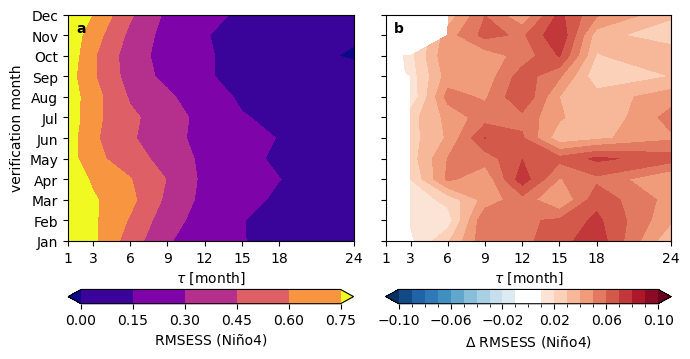

In [15]:
# Plot skill score
metrickey = 'rmse_skill_vmonth'
lag = 12
nino_idx = 'nino4'
model_name = ['CS-LIM', 'Hybrid-model']
alpha = 0.95

pltspec = {
    'crps_vmonth' : dict(cmap='plasma_r', vmin=0, vmax=0.6, eps=0.05),
    'rmse_skill_vmonth' : dict(cmap='plasma', vmin=0, vmax=0.9, eps=0.05),
}
score_label = dict(rmse_skill_vmonth=f'RMSESS ({nino_label[nino_idx]})', crpss=f'CRPSS ({nino_label[nino_idx]})')

ncols = len(model_name) 
fig, axs = plt.subplots(1, ncols, 
                        figsize=(7, 3.7),
                        sharex=True, sharey=True)

modelkey = model_name[0]
metric_month = metric_storer[modelkey][metrickey]
ax = axs[0]
skill_buff = metric_month[nino_idx].mean(dim='member')        
im = ax.contourf(skill_buff['lag'], skill_buff['month'], skill_buff.data,
                 **pltspec[metrickey], extend='both')

ax.set_xticks(skill_buff['lag'])
ax.set_xlabel(rf"$\tau$ [month]")
ax.set_yticks(skill_buff['month'])
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('verification month')
#ax.set_title(f"{modelkey}")

fig.colorbar(im, ax=ax, orientation='horizontal', extend='both',
             label=rf"{score_label[metrickey]}")

# Difference plot
pltspec = dict(cmap='RdBu_r', vmin=-0.1, vmax = 0.1, eps=0.01, centercolor="#FFFFFF")
ax = axs[1] 
skill_diff, pvalues = metric.mean_diff(metric_storer[model_name[1]][metrickey][nino_idx],
                                       metric_storer[model_name[0]][metrickey][nino_idx],
                                       dim='member')
if pvalues is not None:        
    skill_diff = xr.where(pvalues<=(1-alpha), skill_diff, np.nan)

im = gpl.contourf(skill_diff, 'lag', 'month', ax=ax,
                  bar='discrete', add_bar=True, **pltspec, 
                  kwargs_pl = dict(extend='both'),
                  kwargs_cb=dict(orientation='horizontal', extend='both', label=rf"$\Delta$ {score_label[metrickey]}")
                  )


ax.set_xticks(skill_buff['lag'])
ax.set_xlabel(rf"$\tau$ [month]")
#ax.set_title(f"{model_name[1]} - {model_name[0]}")

im['cb'].set_ticks(np.arange(pltspec['vmin'], pltspec['vmax']+pltspec['eps'], 4*pltspec['eps']))

gpl.enumerate_axes(axs, pos_x=0.03, pos_y=0.97, fontsize='medium')

plt.savefig(f"../../output/paperplots/seasonal_skill_lag{lag}.jpg", bbox_inches='tight', dpi=1000)

## Compute metric using bootstrapping

In [25]:
# Compute skill
def bootstrapped_metrics(indices_storer, n_bootstraps=1000):
    if 'frcst' in indices_storer.keys(): 
        if 'member' in indices_storer['frcst'].dims: 
            frcst_mean = indices_storer['frcst'].mean(dim='member')
            frcst_std = indices_storer['frcst'].std(dim='member') 
        else:
            frcst_mean = indices_storer['frcst']
            frcst_std = None
    else:
        frcst_mean = indices_storer['frcst_mean']
        frcst_std = indices_storer['frcst_std']

    target = indices_storer['target']

    metrics_storer = dict() 
    # Metrics averaged over the whole time series 
    # ===========================================
    resampled_metrics = {'mse':[], 'rmse':[], 'rmsess':[], 'crps':[], 'crpss':[], 'cc':[],
                         'mse_vmonth':[], 'rmse_vmonth':[], 'rmsess_vmonth':[],
                         'crps_vmonth':[], 'crpss_vmonth':[]}
    # STD of target
    std = target.std(dim='time', skipna=True)
    std_month = target.groupby(f'time.month').std(dim=('time'), skipna=True)

    # Resample time series
    for _ in tqdm(range(n_bootstraps)):
        resample_time = np.random.choice(target.time, size=len(target.time), replace=True)
        resampled_target = target.sel(time=resample_time)
        resampled_frcst_mean = frcst_mean.sel(time=resample_time)

        # MSE
        resampled_mse = ((resampled_target - resampled_frcst_mean)**2).mean(dim='time', skipna=True)
        resampled_metrics['mse'].append(resampled_mse)

        # RMSE skill score
        resampled_rmse = np.sqrt(resampled_mse)
        resampled_metrics['rmse'].append(resampled_rmse)
        resampled_rmsess = 1 - resampled_rmse/std
        resampled_metrics['rmsess'].append(resampled_rmsess)

        # Correlation coefficient
        resampled_corr = xr.merge([
                xr.corr(resampled_target[var], resampled_frcst_mean[var], dim='time') for var in resampled_target.data_vars
        ])
        resampled_metrics['cc'].append(resampled_corr)

        if frcst_std is not None:
            resampled_frcst_std = frcst_std.sel(time=resample_time)
            # CRPS
            resampled_crps = metric.crps_gaussian(resampled_target, resampled_frcst_mean, resampled_frcst_std).mean(dim='time')
            resampled_metrics['crps'].append(resampled_crps)

            crps_reference = metric.crps_gaussian(target, xr.zeros_like(frcst_mean), std*xr.ones_like(frcst_std)).mean(dim='time')
            resampled_crpss = 1 - (resampled_crps/ crps_reference)
            resampled_metrics['crpss'].append(resampled_crpss)

        # Metrics for each verification month 
        # ===========================================
        # MSE
        mse_vmonth = ((resampled_target - resampled_frcst_mean)**2).groupby(f'time.month').mean(dim=('time'), skipna=True)
        resampled_metrics['mse_vmonth'].append(mse_vmonth)
        # RMSE skill score
        rmse_vmonth = np.sqrt(mse_vmonth)
        resampled_metrics['rmse_vmonth'].append(rmse_vmonth)
        rmsess_vmonth = 1 - rmse_vmonth/std_month
        resampled_metrics['rmsess_vmonth'].append(rmsess_vmonth)

        if frcst_std is not None:
            # CRPS
            crps_month = metric.crps_gaussian(
                resampled_target, resampled_frcst_mean, resampled_frcst_std
            ).groupby(f'time.month').mean(dim=('time'))
            crps_month_reference = metric.crps_gaussian(target, xr.zeros_like(frcst_mean),
                                                        std*xr.ones_like(frcst_std)).groupby('time.month').mean(dim='time')
            resampled_metrics['crps_vmonth'].append(crps_month)
            resampled_metrics['crpss_vmonth'].append(1 - crps_month / crps_month_reference)

    # Concatenate resampled metrics
    for key, score in resampled_metrics.items():
        metrics_storer[key] = xr.concat(score, dim='sample')

    return metrics_storer

bootstrapped_metric_storer = {}
for model_key in ['CS-LIM', 'Hybrid-model']:
    indices_storer = model_indices[model_key]
    indices_storer = indices_storer[0] # Select only first member
    print(f"Compute bootstrapped metrics of {model_key}")
    bootstrapped_metric_storer[model_key] = bootstrapped_metrics(indices_storer, n_bootstraps=500)

Compute bootstrapped metrics of CS-LIM


100%|██████████| 500/500 [03:30<00:00,  2.38it/s]


Compute bootstrapped metrics of Hybrid-model


100%|██████████| 500/500 [03:23<00:00,  2.46it/s]


/tmp/ipykernel_15981/3251071895.py:24: UserWarning: The following kwargs were not used by contour: 'eps'
  im = ax.contourf(skill_buff['lag'], skill_buff['month'], skill_buff.data,


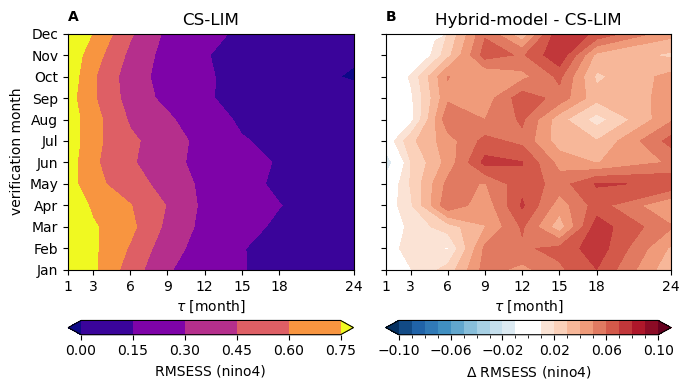

In [46]:
from forenso.utils import stats
# Plot skill score
metrickey = 'rmsess_vmonth'
lag = 12
nino_idx = 'nino4'
model_name = ['CS-LIM', 'Hybrid-model']
alpha = 0.95

pltspec = {
    'crps_vmonth' : dict(cmap='plasma_r', vmin=0, vmax=0.6, eps=0.05),
    'rmsess_vmonth' : dict(cmap='plasma', vmin=0, vmax=0.9, eps=0.05),
}
score_label = dict(rmsess_vmonth=f'RMSESS ({nino_idx})', crpss=f'CRPSS ({nino_idx})')

ncols = len(model_name) 
fig, axs = plt.subplots(1, ncols, 
                        figsize=(7, 4),
                        sharex=True, sharey=True)

modelkey = model_name[0]
metric_month = bootstrapped_metric_storer[modelkey][metrickey]
ax = axs[0]
skill_buff = metric_month[nino_idx].mean(dim='sample')        
im = ax.contourf(skill_buff['lag'], skill_buff['month'], skill_buff.data,
                 **pltspec[metrickey], extend='both')

ax.set_xticks(skill_buff['lag'])
ax.set_xlabel(rf"$\tau$ [month]")
ax.set_yticks(skill_buff['month'])
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('verification month')
ax.set_title(f"{modelkey}")

fig.colorbar(im, ax=ax, orientation='horizontal', extend='both',
             label=rf"{score_label[metrickey]}")

# Difference plot
pltspec = dict(cmap='RdBu_r', vmin=-0.1, vmax = 0.1, eps=0.01, centercolor="#FFFFFF")
ax = axs[1] 
skill_diff, pvalues = metric.mean_diff(bootstrapped_metric_storer[model_name[1]][metrickey][nino_idx],
                                       bootstrapped_metric_storer[model_name[0]][metrickey][nino_idx],
                                       dim='sample')
if pvalues is not None:        
    skill_diff = xr.where(pvalues<=(1-alpha), skill_diff, np.nan)

im = gpl.contourf(skill_diff, 'lag', 'month', ax=ax,
                  bar='discrete', add_bar=True, **pltspec, 
                  kwargs_pl = dict(extend='both'),
                  kwargs_cb=dict(orientation='horizontal', extend='both', label=rf"$\Delta$ {score_label[metrickey]}")
                  )

ax.set_xticks(skill_buff['lag'])
ax.set_xlabel(rf"$\tau$ [month]")
ax.set_title(f"{model_name[1]} - {model_name[0]}")

im['cb'].set_ticks(np.arange(pltspec['vmin'], pltspec['vmax']+pltspec['eps'], 4*pltspec['eps']))

gpl.enumerate_axes(axs, pos_x=0.00, pos_y=1.1, fontsize='medium')
plt.savefig(f"../../output/paperplots/seasonal_skill_lag{lag}.jpg", bbox_inches='tight', dpi=1000)